In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from colorama import Fore

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats
import math

from tqdm.notebook import tqdm
from copy import deepcopy

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch

In [ ]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

plt.rcParams['axes.facecolor'] = primary_bgcolor

In [ ]:
colors = [primary_blue, primary_blue2, primary_blue3, primary_grey, primary_black, primary_bgcolor, primary_green]
sns.palplot(sns.color_palette(colors))

In [ ]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = 'serif'

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Tabular Playground Series 📚 - April 2021 📈</p>

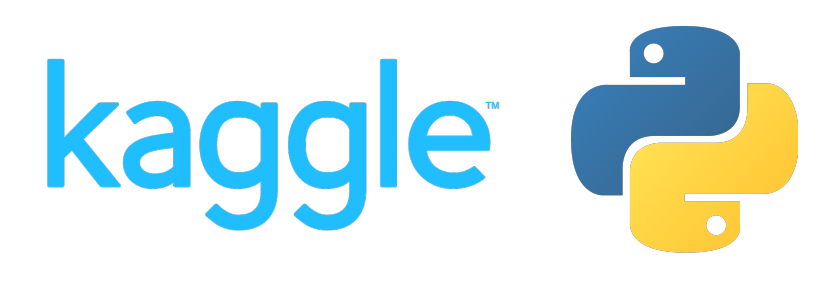

<a id='table-of-contents'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Data visualization: Survival Analysis 📊](#1)
    * [1.1 Target](#1.1)
    * [1.2 Data missings](#1.2)
    * [1.3 Numerical Columns](#1.3)
    * [1.4 Categorical Columns](#1.4)
    * [1.5 Global correlation matrix](#1.5)
* [2. Data visualization: Compare Train and Test 📊](#2)
    * [2.1 Categorical Features](#2.1)
    * [2.2 Age](#2.2)
    * [2.3 Fare](#2.3)
    * [2.4 Cabin](#2.4)
* [3. Feature Engineering 🛠](#3)
    * [3.1 Add new Features](#3.1)
* [4. LightAutoML](#4)


In [ ]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/train.csv')
train_df.columns = [column.lower() for column in train_df.columns]
# train_df = train_df.drop(columns=['passengerid'])

test_df = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/test.csv')
test_df.columns = [column.lower() for column in test_df.columns]

submission = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv')
submission.head()

train_df.head()

In [ ]:
feature_cols = train_df.drop(['survived', 'passengerid'], axis=1).columns
target_column = 'survived'

## Getting all the data that are not of "object" type. 
numerical_columns = ['age', 'fare']
categorical_columns = train_df[feature_cols].drop(columns=numerical_columns).columns

pure_num_cols = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
pure_cat_cols = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

print(len(numerical_columns), len(categorical_columns))

<a id='1'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Data visualization: First Overview 📊</p>

In [ ]:
train_df.info()

The first thing that we can see is that we have some missing that we will have to handle later and that, as we knew, there are categorical and numerical features. 

Also, we know that the class is binary.

<a id='1.1'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.1 Target Variable</p>

The first thing we are going to check is the distribution of the target feature. It's important to know if the class is balanced or not. If so, we would probably have to handle it.

In [ ]:
fig = px.histogram(
    train_df, 
    x=target_column, 
    color=target_column,
    color_discrete_sequence=[primary_blue, primary_grey],
)
fig.update_layout(
    title_text='Target distribution', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.show()

<a id='1.2'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.2 Data missings</p>

In this section we are going to take a fast look about the null values and their distribution.
We will handle those missing later,m but is important to have a first reference.

Ref: https://www.kaggle.com/subinium/tps-apr-highlighting-the-data

In [ ]:
nan_data = (train_df.isna().sum().sort_values(ascending=False) / len(train_df) * 100)[:6]
fig, ax = plt.subplots(1,1,figsize=(7, 5))

ax.bar(nan_data.index, 100, color=primary_grey, width=0.6)

bar = ax.bar(
    nan_data.index, 
    nan_data, 
    color=primary_blue, 
    width=0.6
)
ax.bar_label(bar, fmt='%.01f %%')
ax.spines.left.set_visible(False)
ax.set_yticks([])
ax.set_title('Null Data Ratio', fontweight='bold')

plt.show()

<a id='1.3'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.3 Numerical features</p>

The first view over numerical variables is about show the diference distributions based on the class. As we can see, the `distplot` are very similar but there are some diferences:
- In `age` feature it seems that people between $18-42$ tends to die with higher probability than those between $40-70$ years
- In `fare` feature, those with lower values tend to die more than those with higher values

In [ ]:
num_rows, num_cols = 2,1
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16), facecolor=primary_bgcolor)
f.suptitle('Distribution of Features', fontsize=20, fontweight='bold', fontfamily='serif', x=0.13)


for index, column in enumerate(train_df[numerical_columns].columns):
    i,j = (index // num_cols, index % num_cols)
    sns.kdeplot(train_df.loc[train_df[target_column] == 0, column], color=primary_grey, shade=True, ax=axes[i])
    sns.kdeplot(train_df.loc[train_df[target_column] == 1, column], color=primary_blue, shade=True, ax=axes[i])

# f.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

### Correlation

About the correlation, we are going to check 2 points of view:
- The correlation between the continuos variables
- The correlation between this continuos features and the target

As we can see, the variables are not high correlation and also, no high correlation with the class, so we are not going to delete any variable.

In [ ]:
corr = train_df[pure_num_cols].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(12, 12), facecolor=primary_bgcolor)
ax.text(-1.1, 0.16, 'Correlation between the Continuous Features', fontsize=20, fontweight='bold', fontfamily='serif')
ax.text(-1.1, 0.3, 'There is no features that pass 0.4 correlation within each other', fontsize=13, fontweight='light', fontfamily='serif')


# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)
# yticks
plt.yticks(rotation=0)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8), facecolor=primary_bgcolor)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(primary_bgcolor)
ax0.text(-1.1, 0.26, 'Correlation of Continuous Features with Target', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.1, 0.24, 'There is no features that pass 0.3 correlation with target', fontsize=13, fontweight='light', fontfamily='serif')

chart_df = pd.DataFrame(train_df[pure_num_cols].corrwith(train_df[target_column]))
chart_df.columns = ['corr']
sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, color=primary_blue, zorder=3, edgecolor='black', linewidth=1.5)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_ylabel('')

for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

<a id='1.4'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.4 Categorical features</p>

In this case we are going to check in general terms, the distribution of categories values based on survival chances:
- In the case of `name` and `cabin` there seems to be no possible information to stract, but will take a dive dive into those ones.
- In the case of `sex` and `embarked` we can see that `females` and those in the high class had more chance to survive

### Individual survival rate

* **Sex**
    * `Female` has higher chance to survived compared to `male`, this may also be the result of lifeboat priority for  `female` than `male`.
    
* **SibSp**
    * Most of the passengers in Synthanic are travel alone, this make the survival rate for passengers without `siblings / spouses` higher than passengers with siblings / spouses.
    
* **Parch**
    * As stated earlier, that most of the passengers in Synthanic are travel alone, this also make the survival rate for passenger that travel without `parents / children` are higher.
    * Survival rate for passengers that travel without `parents / children` is almost the same with the survival rate for passenger that travel without `siblings / spouses`.
    
* **Embarked**
    * Passengers that embarked from `Southampton` have the highest chance to survived.
    * The second highest survival rate are passengers that embarked from `Cherbourg`.

In [ ]:
train_0_df = train_df.loc[train_df[target_column] == 0]
train_1_df = train_df.loc[train_df[target_column] == 1]

num_rows, num_cols = 4,2
fig = make_subplots(rows=num_rows, cols=num_cols)

for index, column in enumerate(train_df[categorical_columns].columns):
    i,j = ((index // num_cols)+1, (index % num_cols)+1)
    data = train_0_df.groupby(column)[column].count().sort_values(ascending=False)
    data = data if len(data) < 10 else data[:10]
    fig.add_trace(go.Bar(
        x = data.index,
        y = data.values,
        name='Label: 0',
        marker_color=primary_grey,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)

    data = train_1_df.groupby(column)[column].count().sort_values(ascending=False)
    data = data if len(data) < 10 else data[:10]
    fig.add_trace(go.Bar(
        x = data.index,
        y = data.values,
        name='Label: 1',
        marker_color=primary_blue,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)
    
    fig.update_xaxes(
        title=column, 
        type='category', 
        row=i, 
        col=j
    )
    fig.update_layout(barmode='stack')
    
fig.update_layout(
    autosize=False,
    width=800,
    height=1300,
    showlegend=False,
    title='<span style="font-size:32px; font-family:Times New Roman">Categorical features</span>',
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.show()

<a id='1.5'></a>
[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">1.5 Global correlation matrix</p>

We can see that name and ticket have very low correlation to survival. We can easily drop them or leave them and engineer some features from them later. Sex, Embarked and Pclass have the highest correlation with survival. The highest feature-to-feature correlation is Cabin-Pclass at 0.625.

In [ ]:
# label encoding
le = LabelEncoder()
le_data = train_df.copy().drop(columns=['passengerid'])

for col in pure_cat_cols:
    le_data[col] = le.fit_transform(le_data[col])  

corrdata = le_data

## correlation 
corr = corrdata.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr1 = corr.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr1.to_numpy().round(2),
    x=list(corr1.index.values),
    y=list(corr1.columns.values),       
    xgap=3, ygap=3,
    zmin=0, zmax=1,
    colorscale='blugrn',
    colorbar_thickness=30,
    colorbar_ticklen=3,
)

fig.update_layout(
    title_text='<span style="font-size:32px; font-family:Times New Roman">Features Correlation Matrix</span>', 
    font_family="Serif",
    titlefont={'size': 24},
    width=800, height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed', 
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
    margin=dict(l=70, r=70, t=70, b=70, pad=1),
)

fig.show()

<a id='2'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data visualization: Compare Train and Test 📊</p>

First of all, thanks a lot to [SharIto Cope](https://www.kaggle.com/dwin183287) for the cool charts and ideas.

This section will try to explore and compare features in the `train` and `test` dataset. It should be noted that some features are not the same between `train` and `test` dataset as can be seen more detail on each sub-sections.

In [ ]:
def plot_train_test_bar(df, column, title='Title not set'):
    fig = px.bar(
        df, 
        x='index',
        y=column,
        color='source',
        color_discrete_sequence=[primary_blue, primary_grey],
    )
    fig.update_xaxes(type='category')
    fig.update_traces(
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    )
    fig.update_layout(
        title_text=title, # title of plot
        xaxis_title_text='Value', # xaxis label
        yaxis_title_text='Count', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        barmode='group',
        paper_bgcolor=primary_bgcolor,
        plot_bgcolor=primary_bgcolor,
    )
    fig.show()
    
def plot_train_test_line(df, column, title='Title not set'):
    fig = go.Figure()
    
    for uvalue in df[column].unique():
        print(uvalue)
        tseries = df.query(f'{column} == "{uvalue}"')[column].value_counts()
        print(tseries)
        fig.add_trace(go.Scatter(
            x = tseries.index,
            y = tseries.values,
        ))
    fig.update_traces(
        opacity=0.8,
    )
    fig.update_layout(
        title_text=title, # title of plot
        xaxis_title_text='Value', # xaxis label
        yaxis_title_text='Count', # yaxis label
        paper_bgcolor=primary_bgcolor,
        plot_bgcolor=primary_bgcolor,
    )
    fig.show()

<a id='2.1'></a>

[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.1 Categorical Features</p>

In [ ]:
num_rows, num_cols = 3,2
fig = make_subplots(
    rows=num_rows, 
    cols=num_cols,
    specs=[[{}, {}],
           [{}, {}],
           [{"colspan": 2}, None]],
)

tmp_categorical_columns = list(set(categorical_columns) - set(['name', 'ticket', 'cabin']))

for index, column in enumerate(tmp_categorical_columns):
    i,j = ((index // num_cols)+1, (index % num_cols)+1)
    
    temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
    temp_train['source'] = 'train'
    
    temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
    temp_test['source'] = 'test'
    
    temp_combine = pd.concat([temp_train, temp_test], axis=0)
    
    fig.add_trace(go.Bar(
        x = temp_train['index'],
        y = temp_train[column],
        name='Train',
        marker_color=primary_blue,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)

    fig.add_trace(go.Bar(
        x = temp_test['index'],
        y = temp_test[column],
        name='Test',
        marker_color=primary_grey,
        marker_line_color=primary_black,
        marker_line_width=1.5, 
        opacity=0.8,
    ), row=i, col=j)
    
    fig.update_xaxes(
        title=column, 
        type='category', 
        row=i, 
        col=j
    )
    fig.update_layout(barmode='group')
    
fig.update_layout(
    autosize=False,
    width=800,
    height=1000,
    showlegend=False,
    title='<span style="font-size:32px; font-family:Times New Roman">Categorical features</span>',
    paper_bgcolor=primary_bgcolor,
    plot_bgcolor=primary_bgcolor,
)
fig.show()

### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Pclass</p>

Pclass is a proxy for socio-economic status (SES) where 1st = Upper, 2nd = Middle and 3rd = Lower. 

* Though `Pclass` is dominated by `class 3` both in `train` and `test` dataset, but the proportions between each classes are different in the `train` and `test` dataset:

    * `Class 3` in `train` dataset contributes `40%` while in `test` dataset, it has a contribution above `60%`.
    * `Class 2` is at a very low of `10%` in `test` dataset while in `train` dataset, it contributes around `30%`.
    * `Class 1` in the `train` and `test` dataset are quite the same but it is higher in the train dataset.
    
### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Embarked</p>

* `Emarked` is the port of embarkation:
    * `C` is Cherbourg
    * `Q` is Queenstown 
    * `S` is Southampton

**Observations:**
* There are 3 port of embarktion, they are `Cherbourg`, `Queenstown` and `Southampton`.
* Most of Titanic passengers are embarked from `Southampton` which contributes almost $70%$ of the passengers.
* There are `205` missing values in `train` dataset and `277` missing values in the `test` dataset.

### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Parch</p>

* `Parch` is the number (#) of parents / children aboard the Titantic syntetic dataset.
* `Parents` are mother and father.
* `Child` are daughter, son, stepdaughter and stepson.
* Some children travelled only with a nanny, therefore `Parch = 0` for them.

**Observations:**
* Number of parents / children can be categorize into `8 categories`, this feature quite resemble the `SibSp` feature so we will apply the same ideas here.
* The highest number of parents / children is `8 people` and the lowest is 0 meaning the passengers is traveling without their parents / childrens.
* It seems that `train` and `test` are equally distributed.
    
### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">Sex</p>

* `Sex` consists of `male` and `female`.
* `Male` is dominating the `sex` feature which contributed more than `50%` of `train` and `test` dataset. 
* Same as `Pclass`, there is a proportion differences beetween `train` and `test` dataset, in `train` dataset `female` contributed more than `40%` while in `test` dataset `female` only contributed `30%` of total dataset.

### <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">SibSp</p>

* `SibSp` is number of siblings / spouses aboard the Titanic syntetic dataset. 
* `Siblings` are brother, sister, stepbrother and stepsister. 
* `Spouses` are husband and wife (mistresses and fiances were ignored)

**Observations:**.

* Number of siblings / spouses can be categorize into `7 categories`. For me, it should be categorical but maybe with `LabelEncoder` insted of `OneHotEncoder` but we will see in the experimentation.
* The highest / maximum number of sibblings / spouses that is going aboard with the passengers are `8 people` and the lowest is traveling without any sibblings / spouses. Most of Synthanic passenger don't travel with their family.
* A notable thing in this feature, there is arround $10k$ differences on passenger that travel with $0$ or $1$ sibbling / spose between `train` and `test` dataset.

In [ ]:
column = 'pclass'

temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Pclass Distribution over Sets</span>',
)

In [ ]:
column = 'embarked'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Embarked Distribution over Sets</span>',
)

In [ ]:
column = 'sex'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Sex Distribution over Sets</span>',
)

In [ ]:
column = 'sibsp'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Sibsp Distribution over Sets</span>',
)

In [ ]:
column = 'parch'
temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Parch Distribution over Sets</span>',
)

<a id='2.2'></a>

[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.2 Age</p>

`Age` is fractional if it less than 1. Age estimation in the form of xx.5.

**Observations:**
* `Age` distribution between `train` and `test` dataset are different.
* There is a big differences in `Age` distribution between `train` and `test` dataset at range of $18-40$. 
* There are missing value in the `train` and `test` dataset, they are $3.292$ and $3.487$, respectively.

Ref: https://www.kaggle.com/dwin183287/tps-apr-2021-eda/

In [ ]:
temp_combine = pd.concat([train_df, test_df], axis=0)

In [ ]:
sns.set_palette(sns.color_palette([primary_blue, primary_grey]))

plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(5, 2), facecolor=primary_bgcolor)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(primary_bgcolor)

ax0.tick_params(axis = "y", which = "both", left = False)

ax0.text(-10, 0.056, 'Age', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-10, 0.055, 'Age distribution showing a bimodal data in train and test dataset',
         color='#292929', fontsize=5, ha='left', va='top')

# KDE plots
ax0_sns = sns.kdeplot(ax=ax0, x=train_df['age'], zorder=2, shade=True)
ax0_sns = sns.kdeplot(ax=ax0, x=test_df['age'], zorder=2, shade=True)

# Axis and grid customization
ax0_sns.set_xlabel("Age",fontsize=5, weight='bold')
ax0_sns.set_ylabel('')
ax0.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE')

# Legend params
ax0.legend(['train', 'test'], prop={'size': 5})
ax0_sns.tick_params(labelsize=5)

plt.show()

<a id='2.3'></a>

[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.3 Fare</p>

`Fare` is the paassenger fare.

**Observations:**
* `Fare` distribution between `train` and `test` seems to be very similar with little diferences.
* The `highest` and teh `lowest` values of fare in the `train` and `test` dataset are more or less close`.
* The `average` fare in `train` dataset and is very close with the one in `test` dataset.
* There are $133 - 134$ missing value in `train` and `test` datasets respectively.

In [ ]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(5, 2), facecolor=primary_bgcolor)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(primary_bgcolor)

ax0.tick_params(axis = "y", which = "both", left = False)

ax0.text(-60, 0.0355, 'Fare', color='black', fontsize=7, ha='left', va='bottom', weight='bold')
ax0.text(-60, 0.035, 'Fare distribution between train and test sets are similar', 
         color='#292929', fontsize=5, ha='left', va='top')

# KDE plots
ax0_sns = sns.kdeplot(ax=ax0, x=train_df['fare'], zorder=2, shade=True)
ax0_sns = sns.kdeplot(ax=ax0, x=test_df['fare'], zorder=2, shade=True)

# Axis and grid customization
ax0_sns.set_xlabel("Age",fontsize=5, weight='bold')
ax0_sns.set_ylabel('')
ax0.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE')

# Legend params
ax0.legend(['train', 'test'], prop={'size': 5})
ax0_sns.tick_params(labelsize=5)

plt.show()

<a id='2.4'></a>

[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">2.4 Cabin</p>

`Cabin` is the cabin number. In the original Titanic Disaster datset, this feature could be converted to a categorical variable by taking the first letter in the feature. 
Also, due to high missing value from this feature, a new `cabin` category `N` was created to address passengers without cabin number.

Anycase, it was the case of the past dataset so we will need to inspect the data latter.

**Observations:**
* Be aware that this feature has the highest number of missing value of $67.866$ in `train` dataset and $70.831$ in `test` dataset, meaaning it's almost $70%$ of the information are missing. 
* As we explained, in previos dataset, cabin could be categorize into `9 categories`, with `N` filling the missing values.
* There is quite a distinct imbalance data between `train` and `test` dataset in cabin `C`. It's near the double.

In [ ]:
column = 'cabin_code'
train_df["cabin"] = train_df["cabin"].fillna("Nan")
train_df["cabin_code"] = train_df["cabin"].str[0]
test_df["cabin"] = test_df["cabin"].fillna("Nan")
test_df["cabin_code"] = test_df["cabin"].str[0]

temp_train = pd.DataFrame(train_df[column].value_counts()).reset_index(drop=False)
temp_train['source'] = 'train'
temp_test = pd.DataFrame(test_df[column].value_counts()).reset_index(drop=False)
temp_test['source'] = 'test'
temp_combine = pd.concat([temp_train, temp_test], axis=0)

plot_train_test_bar(
    temp_combine, 
    column,
    title = '<span style="font-size:36px; font-family:Times New Roman">Cabin Distribution over Sets</span>',
)

<a id='3'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Feature Engineering 🛠</p>

In this section we are going to tune the features and customize them the improve the results. We will also try to continue with original Titanic feature engineering.

The first this we are going to check is [Original Titanic Dataset and Feature Engineering](https://www.kaggle.com/andreshg/titanic-dicaprio-s-safety-guide-h2o-automl) to see which were the techniques that we have used.

Ref: https://www.kaggle.com/carlmcbrideellis/synthanic-feature-engineering-beware

After taking a look of the past feature engineering techniques we can see that:
> One of the keys to success, besides overfitting and underfitting the Titanic, is feature selection and feature engineering.

But in this case, it's synthetic data, so we are not able to do the same. As Carl said:

> When creating synthetic data it is very tricky to maintain the relationships between columns. These are known as constraints. For example, imagine creating two columns of synthetic data, `Country` and `City`. When creating synthetic data it is easy to populate the `Country` column by randomly selecting countries from a list of all countries, and the same goes for `City`. However, in real world data one would expect that there are certain cities that belong in certain countries. If one does not apply such a constraint, this relationship between the two columns is lost.

In [ ]:
train_df.query('ticket == "10867"')

we can see that in the data there are 8 people with the very same Ticket number embarked at Cherbourg and Southampton, and the passenger class (`Pclass`) was variously 1st, 2nd or 3rd, and indeed many of them were seemingly traveling alone.

In [ ]:
train_df.query('cabin == "C11139"')

we can see that 5 people from two ports chose to share this spacious first class cabin. Walter Yancy and Tony Lower paid £221.85 and £264.83 each. However, Erika COnley had a great deal, paying only £33.69 (but probably had to sleep on the floor...)

### Conclusiones

Directly citting from Carl...

> We can see here in this small example that the 'story' that the women from the 1st and 2nd class had better survival that including women form all classes has changed between the Titanic dataset and the Synthanic dataset. We can also see that some of the feature engineering that works for the Titanic does not work for the Synthanic. So beware when it comes to Synthanic feature engineering!

<a id='3.1'></a>

[back to top](#table-of-contents)
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">4.1 Add new Features</p>

In this case, we will apply distinct methods for each features to fill NaNs and add new ones
- As we dont have any information regardin cabian because of the synthetic origin of the data, we are going to just fill it
- As `age` is correlated the most with Pclass (0.26) we will fill `age` nans feature based on `pclass mean age`
- As `fare` is correlated the most with Pclass (0.41) we will fill `fare` nans feature based on `pclass mean fare`
- In the case of `name`, we will only get the surname

Ref: https://www.kaggle.com/alexryzhkov/n3-tps-april-21-lightautoml-starter
Ref: https://www.kaggle.com/tunguz/tps-april-2021-feature-eng-only

In [ ]:
train_df.head()

In [ ]:
def fix_features(all_df):
    # Fillna on cabin feature
    all_df["cabin"] = all_df["cabin"].fillna("Nan")
    all_df["cabin"] = all_df["cabin"].str[0]

    # Fillna Age based on pclass
    map_age_pclass = all_df[['age', 'pclass']].dropna().groupby('pclass').mean().to_dict()
    all_df['age'] = all_df['age'].mask(all_df['age'].isna(), all_df['pclass'].map(map_age_pclass['age']))

    print(all_df['age'].isna().sum())

    # Fillna Age based on pclass
    map_age_pclass = train_df[['fare', 'pclass']].dropna().groupby('pclass').mean().to_dict()
    all_df['fare'] = all_df['fare'].mask(all_df['fare'].isna(), all_df['pclass'].map(map_age_pclass['fare']))

    print(all_df['fare'].isna().sum())

    # Ticket, fillna with 'X', split string and take first split 
    all_df['ticket'] = all_df['ticket'].map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
    
    # Name, take only surnames
    all_df['name'] = all_df['name'].apply(lambda x: str(x).split(',')[0])
    
    return all_df

In [ ]:
all_df = pd.concat([train_df, test_df]).reset_index(drop = True)

all_df = fix_features(all_df)

train_df, test_df = all_df[:len(train_df)], all_df[len(train_df):]
print(train_df.shape, test_df.shape)

<a id='4'></a>
[back to top](#table-of-contents)
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. LightAutoML</p>

In this section I will implement [Alexander's LightAutoML](https://www.kaggle.com/alexryzhkov) library as a base model for the Syntanic problem. The main idea is to show the power of this library an get a base score to compare with the future models.

Ref: https://www.kaggle.com/alexryzhkov/tps-april-21-lightautoml-starter

In [ ]:
!pip install -U lightautoml

In [ ]:
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

In [ ]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

In [ ]:
roles = {
    'target': 'survived',
    'drop': ['passengerid', 'name','ticket'],
}

In [ ]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

In [ ]:
%%time

test_pred = automl.predict(test_df)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train_df['survived'].values, oof_pred.data[:, 0])))

In [ ]:
submission['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)
submission.to_csv('lightautoml_utilized_300s_f1_metric.csv', index = False)